In [9]:
import requests
import pandas as pd
import json

def get_car_data(make="Toyota", year=2020):
    url = f"https://www.carqueryapi.com/api/0.3/?cmd=getTrims&make={make}&year={year}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API request failed with status {response.status_code}")
    
    text = response.text.strip()
    print("Raw API response preview:", repr(text[:200]))
    
    # Extract JSON substring by finding the first '{' and the last '}'
    try:
        start = text.index('{')
        end = text.rindex('}') + 1
        json_str = text[start:end]
    except ValueError:
        print("Could not find JSON object in response.")
        return pd.DataFrame()
    
    try:
        data = json.loads(json_str)
    except json.JSONDecodeError as e:
        print("JSON decoding failed:", e)
        return pd.DataFrame()
    
    trims = data.get("Trims", [])
    
    if not trims:
        print(f"No car trims found for make '{make}' and year '{year}'.")
        return pd.DataFrame()
    
    cars = []
    for car in trims:
        cars.append({
            "Make": car.get("model_make_id"),
            "Model": car.get("model_name"),
            "Year": car.get("model_year"),
            "Horsepower (PS)": car.get("model_engine_power_ps"),
            "Fuel Type": car.get("model_engine_fuel"),
            "Transmission": car.get("model_transmission_type"),
            "Price": car.get("model_price"),
            "Mileage (L/100km)": car.get("model_lkm_mixed")
        })
    
    return pd.DataFrame(cars)

# Try fetching data
df = get_car_data("Toyota", 2020)
print(df.head())


Raw API response preview: '{"Trims":[{"model_id":"78228","model_make_id":"Toyota","model_name":"4Runner","model_trim":"Limited 4dr SUV (4.0L 6cyl 5A)","model_year":"2020","model_body":"Sport Utility Vehicles","model_engine_posi'
     Make    Model  Year Horsepower (PS)         Fuel Type Transmission Price  \
0  Toyota  4Runner  2020             270  Regular Unleaded    Automatic  None   
1  Toyota  4Runner  2020             270  Regular Unleaded    Automatic  None   
2  Toyota  4Runner  2020             270  Regular Unleaded    Automatic  None   
3  Toyota  4Runner  2020             270  Regular Unleaded    Automatic  None   
4  Toyota  4Runner  2020             270  Regular Unleaded    Automatic  None   

  Mileage (L/100km)  
0              19.0  
1              18.0  
2              19.0  
3              18.0  
4              19.0  


In [13]:
import requests
import pandas as pd
import numpy as np
import re
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def get_car_data(make, year):
    url = f"https://www.carqueryapi.com/api/0.3/?cmd=getTrims&make={make}&year={year}"
    headers = {
        "User-Agent": "Mozilla/5.0"
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        raise Exception(f"API request failed with status {response.status_code}")

    text = response.text.strip()

    # Check if response is pure JSON or JSONP
    if text.startswith("{") or text.startswith("["):
        # Pure JSON, parse directly
        data = json.loads(text)
    else:
        # Probably JSONP, extract JSON inside parentheses
        match = re.search(r'\((\{.*\})\)', text)
        if not match:
            raise Exception("Failed to extract JSON from API response")
        json_str = match.group(1)
        data = json.loads(json_str)

    trims = data.get("Trims", [])
    
    cars = []
    for trim in trims:
        try:
            hp = int(trim.get("model_engine_power_ps") or 0)
            mileage = float(trim.get("model_lkm_hwy") or 0)
            year_ = int(trim.get("model_year") or year)
            # Synthetic price (since API has no price data)
            price = 10000 + hp * 120 + (year_ - 2000) * 500 + np.random.randint(-2000, 2000)
            cars.append({
                "Horsepower (PS)": hp,
                "Mileage (L/100km)": mileage,
                "Year": year_,
                "Price": price
            })
        except Exception:
            continue

    return pd.DataFrame(cars)

# Fetch data
df = get_car_data("toyota", 2020)

# Clean data
df = df[(df["Horsepower (PS)"] > 0) & (df["Price"] > 0)]

# Features and target
X = df[["Horsepower (PS)", "Mileage (L/100km)", "Year"]]
y = df["Price"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}")

# Predict example
new_car = pd.DataFrame({
    "Horsepower (PS)": [180],
    "Mileage (L/100km)": [7.5],
    "Year": [2021]
})
predicted_price = model.predict(new_car)
print(f"Predicted price for the new car: ${predicted_price[0]:,.2f}")


Mean Squared Error: 1561641.45
R^2 Score: 0.99
Predicted price for the new car: $40,695.71


In [14]:
import requests
import pandas as pd
import numpy as np
import re
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def get_car_data(make, year):
    url = f"https://www.carqueryapi.com/api/0.3/?cmd=getTrims&make={make}&year={year}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status {response.status_code}")

    text = response.text.strip()

    # Handle JSON or JSONP
    if text.startswith("{") or text.startswith("["):
        data = json.loads(text)
    else:
        match = re.search(r'\((\{.*\})\)', text)
        if not match:
            raise Exception("Failed to extract JSON from API response")
        json_str = match.group(1)
        data = json.loads(json_str)

    trims = data.get("Trims", [])
    
    cars = []
    for trim in trims:
        try:
            hp = int(trim.get("model_engine_power_ps") or 0)
            mileage = float(trim.get("model_lkm_hwy") or 0)
            year_ = int(trim.get("model_year") or year)
            # Feature: Engine displacement in liters
            engine_cc = int(trim.get("model_engine_cc") or 0)
            engine_l = engine_cc / 1000 if engine_cc > 0 else 0
            # Synthetic price (since API has no price data)
            price = 10000 + hp * 120 + (year_ - 2000) * 500 + engine_l * 1000 + np.random.randint(-2000, 2000)
            cars.append({
                "Horsepower (PS)": hp,
                "Mileage (L/100km)": mileage,
                "Year": year_,
                "Engine_L": engine_l,
                "Price": price
            })
        except Exception:
            continue

    return pd.DataFrame(cars)

# Fetch data
df = get_car_data("toyota", 2020)

# Preprocessing
# Drop rows with zero or missing values for important features
df = df[(df["Horsepower (PS)"] > 0) & (df["Mileage (L/100km)"] > 0) & (df["Price"] > 0)]

# Feature engineering: Add car age
df["Car_Age"] = 2025 - df["Year"]  # Assuming current year is 2025 for this example

# Define features and target
features = ["Horsepower (PS)", "Mileage (L/100km)", "Engine_L", "Car_Age"]
X = df[features]
y = df["Price"]

# Scaling features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction and evaluation
y_pred = model.predict(X_test)
print("Model Evaluation:")
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}")

# Example prediction with scaling
new_car = pd.DataFrame({
    "Horsepower (PS)": [180],
    "Mileage (L/100km)": [7.5],
    "Engine_L": [2.5],
    "Car_Age": [5]  # example car age
})

new_car_scaled = scaler.transform(new_car)
predicted_price = model.predict(new_car_scaled)
print(f"Predicted price for the new car: ${predicted_price[0]:,.2f}")


Model Evaluation:
Mean Squared Error: 1287250.31
R^2 Score: 0.99
Predicted price for the new car: $43,399.40


Mean Squared Error: 1679712.46
R^2 Score: 0.99


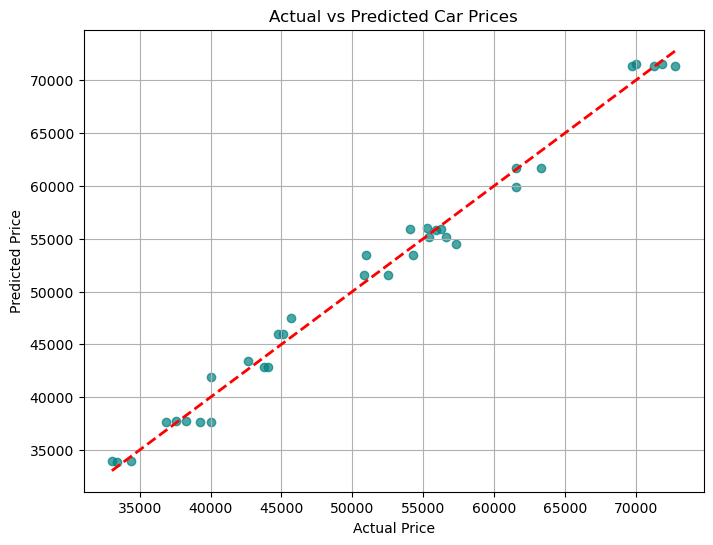

In [15]:
import requests
import pandas as pd
import numpy as np
import re
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def get_car_data(make, year):
    url = f"https://www.carqueryapi.com/api/0.3/?cmd=getTrims&make={make}&year={year}"
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"API request failed with status {response.status_code}")

    text = response.text.strip()

    # Handle JSON or JSONP response
    if text.startswith("{") or text.startswith("["):
        data = json.loads(text)
    else:
        match = re.search(r'\((\{.*\})\)', text)
        if not match:
            raise Exception("Failed to extract JSON from API response")
        json_str = match.group(1)
        data = json.loads(json_str)

    trims = data.get("Trims", [])
    
    cars = []
    for trim in trims:
        try:
            hp = int(trim.get("model_engine_power_ps") or 0)
            mileage = float(trim.get("model_lkm_hwy") or 0)
            year_ = int(trim.get("model_year") or year)
            engine_cc = int(trim.get("model_engine_cc") or 0)
            engine_l = engine_cc / 1000 if engine_cc > 0 else 0
            
            # Synthetic price formula (for demo purposes)
            price = 10000 + hp * 120 + (year_ - 2000) * 500 + engine_l * 1000 + np.random.randint(-2000, 2000)
            
            cars.append({
                "Horsepower (PS)": hp,
                "Mileage (L/100km)": mileage,
                "Year": year_,
                "Engine_L": engine_l,
                "Price": price
            })
        except Exception:
            continue

    return pd.DataFrame(cars)

# Fetch data
df = get_car_data("toyota", 2020)

# Data preprocessing
df = df[(df["Horsepower (PS)"] > 0) & (df["Mileage (L/100km)"] > 0) & (df["Price"] > 0)]

# Feature engineering
df["Car_Age"] = 2025 - df["Year"]

features = ["Horsepower (PS)", "Mileage (L/100km)", "Engine_L", "Car_Age"]
X = df[features]
y = df["Price"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R^2 Score: {r2:.2f}")

# Visualization: Actual vs Predicted prices
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices")
plt.grid(True)
plt.show()
